# Sentiment Analysis on Amazon Fine Food Reviews

We are going to use **3 different approaches for sentiment analysis** with Python:

1. [Valence Aware Dictionary and sEntiment Reasoner (VADER)](#VADER-Model) - Bag of words approach
2. [Roberta Pre-trained model](#Roberta-Pre-trained-Model) from Hugging Face 🤗  
3. [Hugging Face Transformers Pipeline](#Hugging-Face-Transformers-Pipeline)

To know where the dataset came from, make sure to go check out my [Kaggle Notebook](https://www.kaggle.com/code/joaquinsamson/preparing-data-for-sentiment-analysis) first before proceeding to read about this analysis.

# Import required libraries

In [1]:
# Data manipulation
import pandas as pd
import pyarrow
import numpy as np

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('ggplot')

# NLP library
import nltk
# Note: Remove the commments and run the following lines of code if you haven't done them yet
# nltk.download('popular') 
# nltk.download('vader_lexicon')

import warnings
warnings.filterwarnings('ignore')

# Load and read the data

In [2]:
filepath = 'data/Reviews_sample_500.parquet'
df = pd.read_parquet(filepath, engine='pyarrow')

df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,246455,B002D4DY8G,A11EXFO14WEJM1,Sudarshan Karkada,0,0,4,1259539200,Good coffee - if you are into flavored coffee,We always brew Starbucks coffee at home and we...
1,115918,B00348F9I8,A2ITC756URQ2PA,Curley,0,0,5,1327968000,Best there is,Tasty and fresh - Just like Grandma used to ma...
2,57803,B000EVOSE4,A2B14PJBB4I1MF,Chris,4,7,1,1299628800,So hard! Not edible!,"<a href=""http://www.amazon.com/gp/product/B000..."
3,517603,B00954NY46,AAYPNKBSZVUBZ,R.C.,2,2,5,1299974400,Nice strong BOLD coffee,Nice strong coffee - smooth but does have a bi...
4,35950,B0085G4A7U,A2CT0K7QK1O1OI,Ressa,0,0,5,1331942400,My favorite of the Vita Coco beverages is this...,The Vita Coco Acai & Pomegranate is the best t...


# Exploratory Data Analysis (EDA)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      500 non-null    int64 
 1   ProductId               500 non-null    object
 2   UserId                  500 non-null    object
 3   ProfileName             500 non-null    object
 4   HelpfulnessNumerator    500 non-null    int64 
 5   HelpfulnessDenominator  500 non-null    int64 
 6   Score                   500 non-null    int64 
 7   Time                    500 non-null    int64 
 8   Summary                 500 non-null    object
 9   Text                    500 non-null    object
dtypes: int64(5), object(5)
memory usage: 39.2+ KB


We've got 500 observations, with 10 columns for this dataset. The columns of interest here are the `'Text'` column where the reviews of the customers themselves are stored, and the `'Score'` column which indicates the rating scores of the customers.

In [4]:
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

We don't seem to have any missing values with this data, which lets us save time from data cleaning.

In [5]:
# Checking the first value of the 'Text' column
df['Text'].values[0]

'We always brew Starbucks coffee at home and we rarely consume flavored coffee. We tried this coffee and liked it.<br /><br />If you enjoy flavored coffee, then you are likely to enjoy this coffee.<br /><br />I wish it brewed a little stronger (bold) coffee.'

In [6]:
df['Score'].value_counts()

Score
5    327
4     61
1     52
3     34
2     26
Name: count, dtype: int64

In [7]:
df['Score'].value_counts(normalize=True)

Score
5    0.654
4    0.122
1    0.104
3    0.068
2    0.052
Name: proportion, dtype: float64

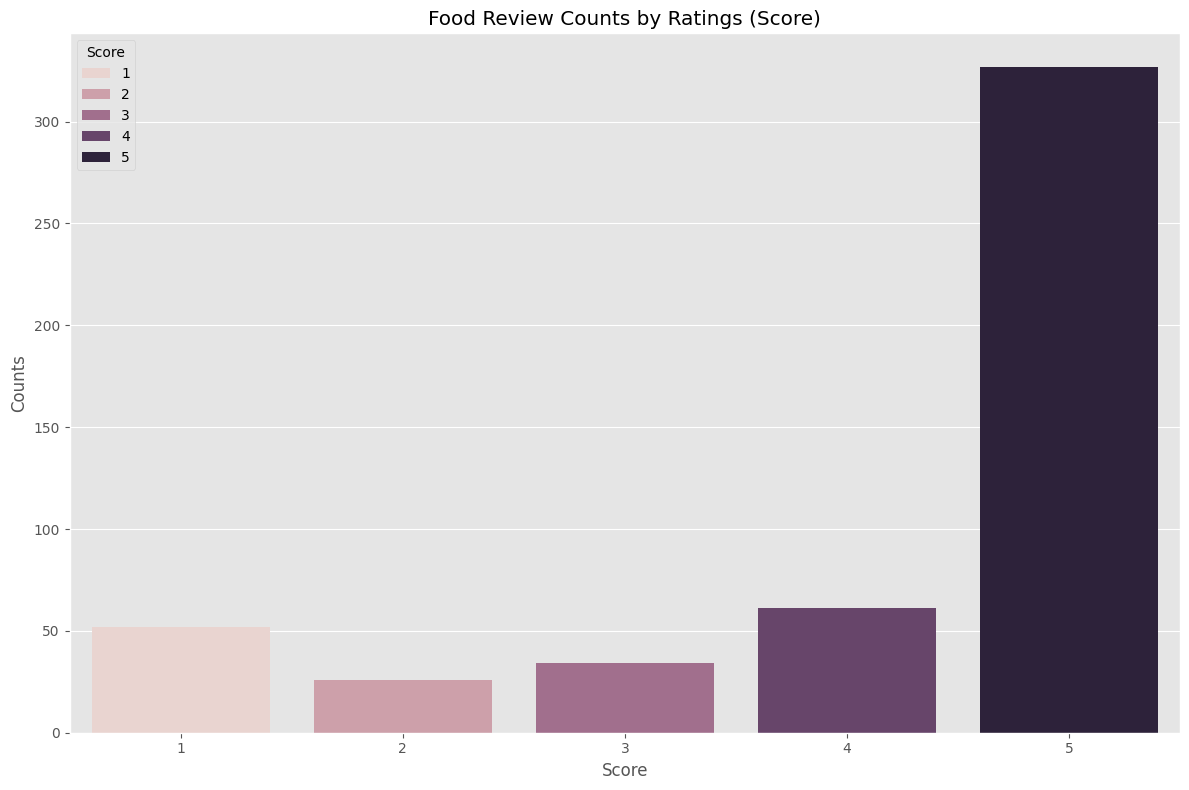

In [8]:
plt.figure(figsize=(12, 8))

sns.countplot(data=df, x='Score', hue='Score')

plt.ylabel('Counts')
plt.title('Food Review Counts by Ratings (Score)')

plt.tight_layout()
plt.show()

After some quick EDA, The randomly sampled data that we have is **heavily skewed towards 5-star rated reviews.** Let's start doing sentiment analysis using the **Natural Language ToolKit (NLTK)** library.

# Perform Basic NLTK

Let's try to perform basic NLTK functions by extracting an observation from our data.

In [9]:
example = df['Text'][20]
print(example)

This is one of the tastiest offerings for my Keurig, rivaling the Gevalia products for my<br />Tassimo. It gives you a large, fragrant cup of coffee at a better price than my Tassimo products which are great but expensive and harder to find.


# Tokenization

In [10]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This',
 'is',
 'one',
 'of',
 'the',
 'tastiest',
 'offerings',
 'for',
 'my',
 'Keurig']

# Tagging

In [11]:
# Parts of speech tagging
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('is', 'VBZ'),
 ('one', 'CD'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('tastiest', 'JJS'),
 ('offerings', 'NNS'),
 ('for', 'IN'),
 ('my', 'PRP$'),
 ('Keurig', 'NNP')]

In [12]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  is/VBZ
  one/CD
  of/IN
  the/DT
  tastiest/JJS
  offerings/NNS
  for/IN
  my/PRP$
  (GPE Keurig/NNP)
  ,/,
  rivaling/VBG
  the/DT
  (GPE Gevalia/NNP)
  products/NNS
  for/IN
  my/PRP$
  </JJ
  br/NN
  //NNP
  >/NNP
  Tassimo/NNP
  ./.
  It/PRP
  gives/VBZ
  you/PRP
  a/DT
  large/JJ
  ,/,
  fragrant/JJ
  cup/NN
  of/IN
  coffee/NN
  at/IN
  a/DT
  better/JJR
  price/NN
  than/IN
  my/PRP$
  Tassimo/NNP
  products/NNS
  which/WDT
  are/VBP
  great/JJ
  but/CC
  expensive/JJ
  and/CC
  harder/NN
  to/TO
  find/VB
  ./.)


# VADER Model

Using the `SentimentIntensityAnalyzer` module of `nltk`, we can output the positive, negative, and neutral scores of text.

This is where we use the bag of words approach:

- Stop word removal
- Word scoring

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

# Create `SentimentIntensityAnalyzer` Object and Function Testing

In [14]:
sia

In [15]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [16]:
sia.polarity_scores('I am very sad.')

{'neg': 0.629, 'neu': 0.371, 'pos': 0.0, 'compound': -0.5256}

In [17]:
sia.polarity_scores('This is the BEST and WORST day of my life!')

{'neg': 0.268, 'neu': 0.443, 'pos': 0.289, 'compound': 0.1007}

In [18]:
print(example)
print(sia.polarity_scores(example))

This is one of the tastiest offerings for my Keurig, rivaling the Gevalia products for my<br />Tassimo. It gives you a large, fragrant cup of coffee at a better price than my Tassimo products which are great but expensive and harder to find.
{'neg': 0.0, 'neu': 0.897, 'pos': 0.103, 'compound': 0.5423}


# Execute Polarity Scoring On the Whole Dataset

In [19]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,246455,B002D4DY8G,A11EXFO14WEJM1,Sudarshan Karkada,0,0,4,1259539200,Good coffee - if you are into flavored coffee,We always brew Starbucks coffee at home and we...
1,115918,B00348F9I8,A2ITC756URQ2PA,Curley,0,0,5,1327968000,Best there is,Tasty and fresh - Just like Grandma used to ma...
2,57803,B000EVOSE4,A2B14PJBB4I1MF,Chris,4,7,1,1299628800,So hard! Not edible!,"<a href=""http://www.amazon.com/gp/product/B000..."
3,517603,B00954NY46,AAYPNKBSZVUBZ,R.C.,2,2,5,1299974400,Nice strong BOLD coffee,Nice strong coffee - smooth but does have a bi...
4,35950,B0085G4A7U,A2CT0K7QK1O1OI,Ressa,0,0,5,1331942400,My favorite of the Vita Coco beverages is this...,The Vita Coco Acai & Pomegranate is the best t...
...,...,...,...,...,...,...,...,...,...,...
495,431544,B000FDN78Y,A248FKDACBQHOU,"Tom Virnig ""Tom V""",2,2,4,1246838400,spiced sardines,I have been looking for these for years. Item...
496,221306,B0009PJRMS,A3674WKSOFOSO5,"Alison Mccarthy ""Alison""",5,5,5,1213920000,Olivella!!!,I adore this soap! I'm not a fan of strong sce...
497,184814,B002EDISKA,A2RL1RS6PWUHWI,Jennifer Ackerman,0,0,5,1337385600,Best jelly beans out there,These are some of the best jelly beans out the...
498,379484,B007RLRCLK,A2NVPRHU3VF05G,"Vanessa Cobian ""Butterfly32""",5,5,5,1304553600,Wonderful Tea.,The tea helped me tremendously with getting a ...


In [20]:
results = {}

for index, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    my_id = row['Id']
    results[my_id] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [21]:
vaders = pd.DataFrame(results).T
vaders = (vaders
              .reset_index()
              .rename(columns={'index': 'Id'})
         )
vaders = vaders.merge(df, how='left')

In [22]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,246455,0.000,0.728,0.272,0.9218,B002D4DY8G,A11EXFO14WEJM1,Sudarshan Karkada,0,0,4,1259539200,Good coffee - if you are into flavored coffee,We always brew Starbucks coffee at home and we...
1,115918,0.000,0.515,0.485,0.9509,B00348F9I8,A2ITC756URQ2PA,Curley,0,0,5,1327968000,Best there is,Tasty and fresh - Just like Grandma used to ma...
2,57803,0.060,0.850,0.090,0.2263,B000EVOSE4,A2B14PJBB4I1MF,Chris,4,7,1,1299628800,So hard! Not edible!,"<a href=""http://www.amazon.com/gp/product/B000..."
3,517603,0.033,0.656,0.311,0.9891,B00954NY46,AAYPNKBSZVUBZ,R.C.,2,2,5,1299974400,Nice strong BOLD coffee,Nice strong coffee - smooth but does have a bi...
4,35950,0.000,0.823,0.177,0.7845,B0085G4A7U,A2CT0K7QK1O1OI,Ressa,0,0,5,1331942400,My favorite of the Vita Coco beverages is this...,The Vita Coco Acai & Pomegranate is the best t...


Merging `vaders` with the original DataFrame `df`, lets us have the sentiment scores for each fine food review.

We can assume that if:

- Scores that are equal to 5 imply that the reviews lean more towards being positive
- Scores that are equal to 1 imply that the reviews lean more towards being negative.

# Plot VADER Results

In [23]:
vaders['Score'].value_counts(normalize=True)

Score
5    0.654
4    0.122
1    0.104
3    0.068
2    0.052
Name: proportion, dtype: float64

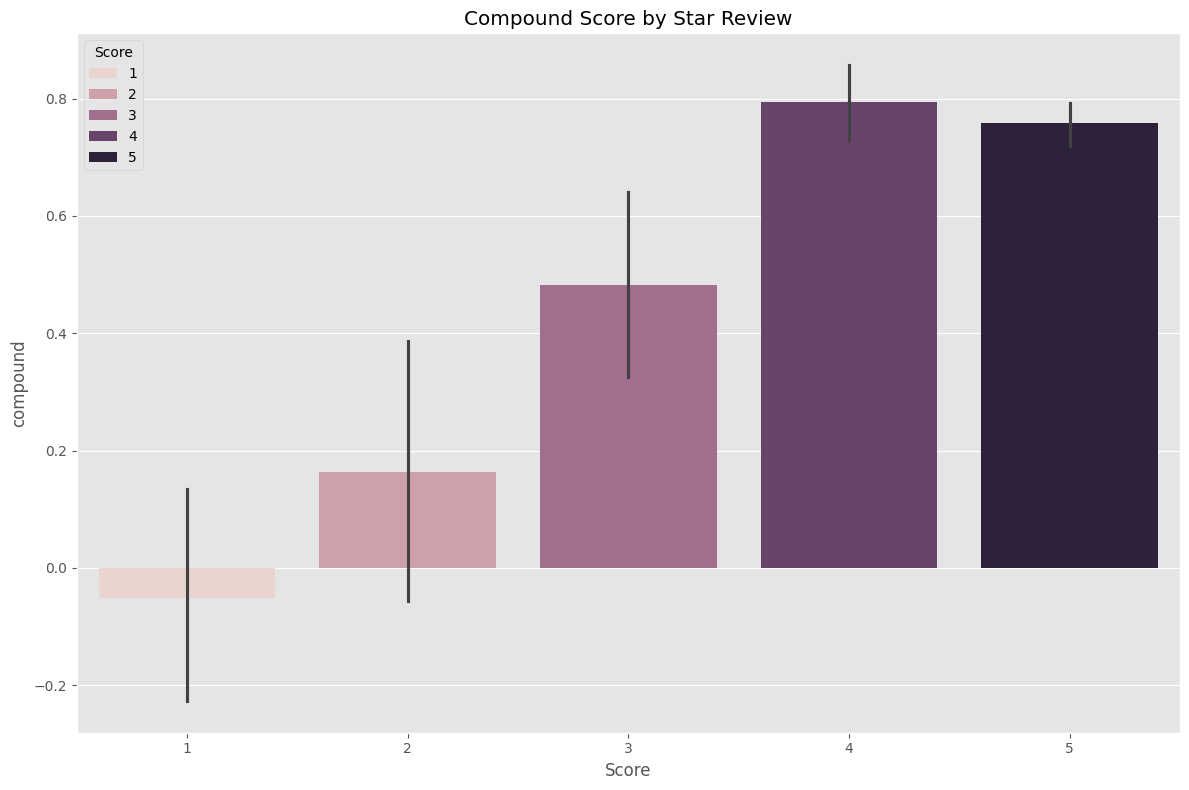

In [24]:
plt.figure(figsize=(12, 8))

ax = sns.barplot(data=vaders, x='Score', y='compound', hue='Score')
ax.set_title('Compound Score by Star Review')

plt.tight_layout()
plt.show()

Our assumptions seem to be aligned with our data.

- The lower the rating, the more negative the review's compound score is
- The higher the rating, the more positive the review's compound score is

Though it's interesting to see that even though the scores are highly skewed towards 5-star ratings, the bar plot seems to be showing that the 4-star rating compound scores are higher than the 5-star rating compound scores.

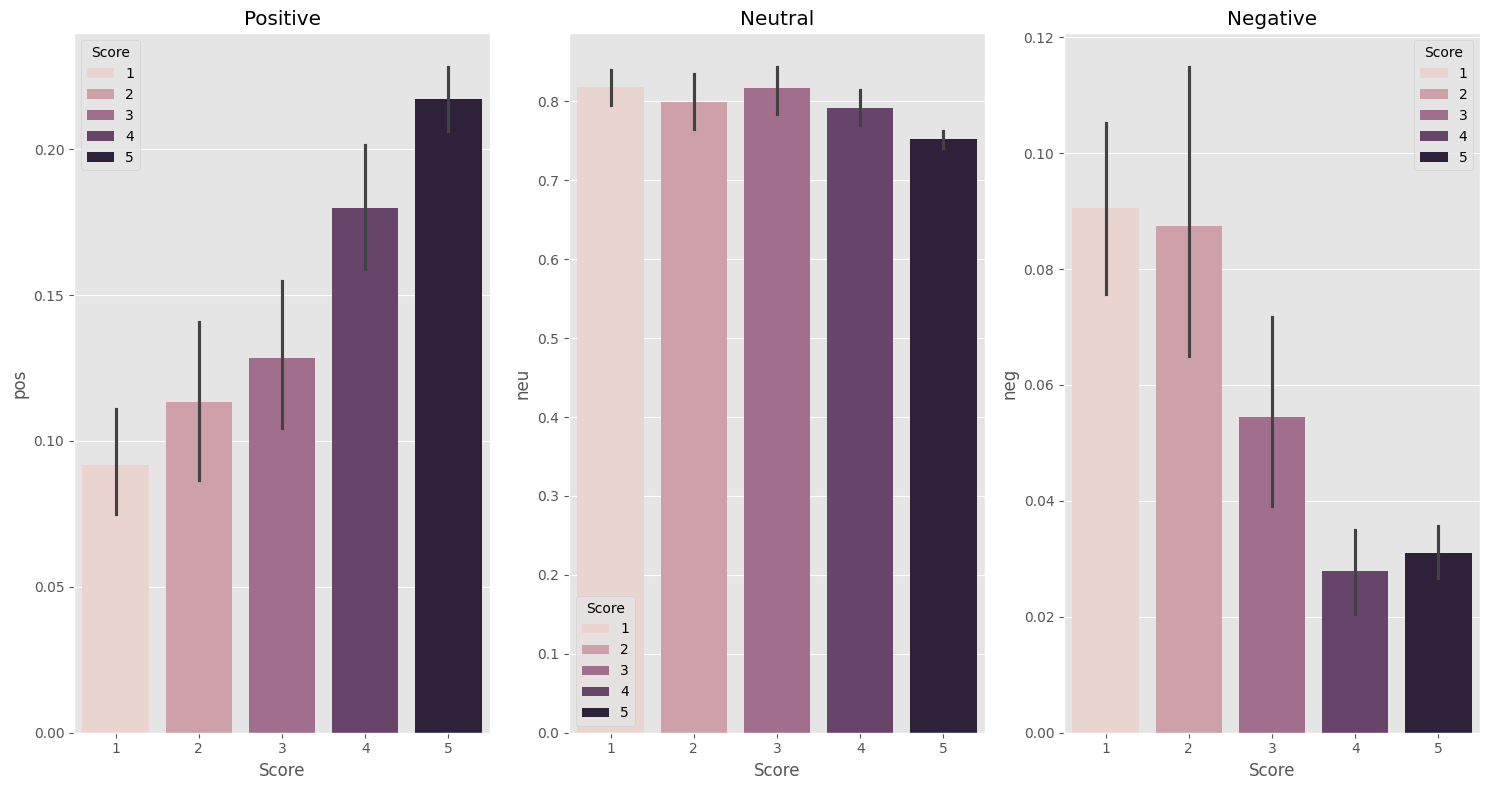

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

sns.barplot(data=vaders, x='Score', y='pos', hue='Score', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', hue='Score', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', hue='Score', ax=axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

plt.tight_layout()

plt.show()

Now we show plots for the positive, neutral, and negative score by ratings. It's nice to see that these scores definitely align well with assumptions:

- **Positive Chart:** High ratings have high positive scores as seen in the bar plots of the 4-star and 5-star ratings of the 1st chart
- **Neutral Chart:** Neutral ratings also have fairly neutral scores as seen in the 3-star rating bar plot of the 2nd chart
- **Negative Chart:** Low ratings have high scores in the 1-star and 2-star ratings as seen in the 3rd chart.

# VADER Model Limitation

The VADER model is a great start towards sentiment analysis, but it's biggest limitation is that **it cannot identify relationships between words**. To address this, we must use more complex models that are able to know the context of a given text, let's try to use a **Roberta Pre-trained Model from Hugging Face.**

# Roberta Pre-trained Model

In [26]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [27]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [28]:
# Recall VADER results
print(example)
sia.polarity_scores(example)

This is one of the tastiest offerings for my Keurig, rivaling the Gevalia products for my<br />Tassimo. It gives you a large, fragrant cup of coffee at a better price than my Tassimo products which are great but expensive and harder to find.


{'neg': 0.0, 'neu': 0.897, 'pos': 0.103, 'compound': 0.5423}

# Run Roberta Model

In [29]:
tokenizer(example, return_tensors='pt')

{'input_ids': tensor([[    0,   713,    16,    65,     9,     5, 24867,  7098,  6984,    13,
           127,  3350,   710,  1023,     6,  3429,   154,     5,   272,  3623,
          6956,   785,    13,   127, 41552,  3809, 48709,   565,  2401, 11332,
             4,    85,  2029,    47,    10,   739,     6, 24275,  6618,  4946,
             9,  3895,    23,    10,   357,   425,    87,   127,   255,  2401,
         11332,   785,    61,    32,   372,    53,  3214,     8,  4851,     7,
           465,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [30]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores

array([0.00279219, 0.02295549, 0.97425234], dtype=float32)

In [31]:
scores_dict = {
    'roberta_negative' : scores[0],
    'roberta_neutral' : scores[1],
    'roberta_positive' : scores[2]
}
print(scores_dict)

{'roberta_negative': 0.00279219, 'roberta_neutral': 0.022955488, 'roberta_positive': 0.97425234}


In [32]:
def roberta_polarity_scores(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_negative' : scores[0],
        'roberta_neutral' : scores[1],
        'roberta_positive' : scores[2]
    }

    return scores_dict

In [33]:
results = {}
for index, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        my_id = row['Id']
        vader_result = sia.polarity_scores(text)
        
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f'vader_{key}'] = value
        
        roberta_result = roberta_polarity_scores(text)
        both = {**vader_result_rename, **roberta_result}
        results[my_id] = both
    except RuntimeError:
        print(f'Broke at {my_id}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke at 58085
Broke at 441093
Broke at 510321


In [34]:
results_df = pd.DataFrame(results).T
results_df = (results_df
                 .reset_index()
                 .rename(columns={'index' : 'Id'}))
results_df = results_df.merge(df, how='left')

In [35]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_negative,roberta_neutral,roberta_positive,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,246455,0.000,0.728,0.272,0.9218,0.020131,0.182910,0.796960,B002D4DY8G,A11EXFO14WEJM1,Sudarshan Karkada,0,0,4,1259539200,Good coffee - if you are into flavored coffee,We always brew Starbucks coffee at home and we...
1,115918,0.000,0.515,0.485,0.9509,0.002378,0.017486,0.980136,B00348F9I8,A2ITC756URQ2PA,Curley,0,0,5,1327968000,Best there is,Tasty and fresh - Just like Grandma used to ma...
2,57803,0.060,0.850,0.090,0.2263,0.443923,0.409082,0.146996,B000EVOSE4,A2B14PJBB4I1MF,Chris,4,7,1,1299628800,So hard! Not edible!,"<a href=""http://www.amazon.com/gp/product/B000..."
3,517603,0.033,0.656,0.311,0.9891,0.005587,0.046992,0.947421,B00954NY46,AAYPNKBSZVUBZ,R.C.,2,2,5,1299974400,Nice strong BOLD coffee,Nice strong coffee - smooth but does have a bi...
4,35950,0.000,0.823,0.177,0.7845,0.001276,0.014607,0.984117,B0085G4A7U,A2CT0K7QK1O1OI,Ressa,0,0,5,1331942400,My favorite of the Vita Coco beverages is this...,The Vita Coco Acai & Pomegranate is the best t...


# Compare VADER and Roberta Model Scores

In [36]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_negative', 'roberta_neutral', 'roberta_positive', 'ProductId',
       'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

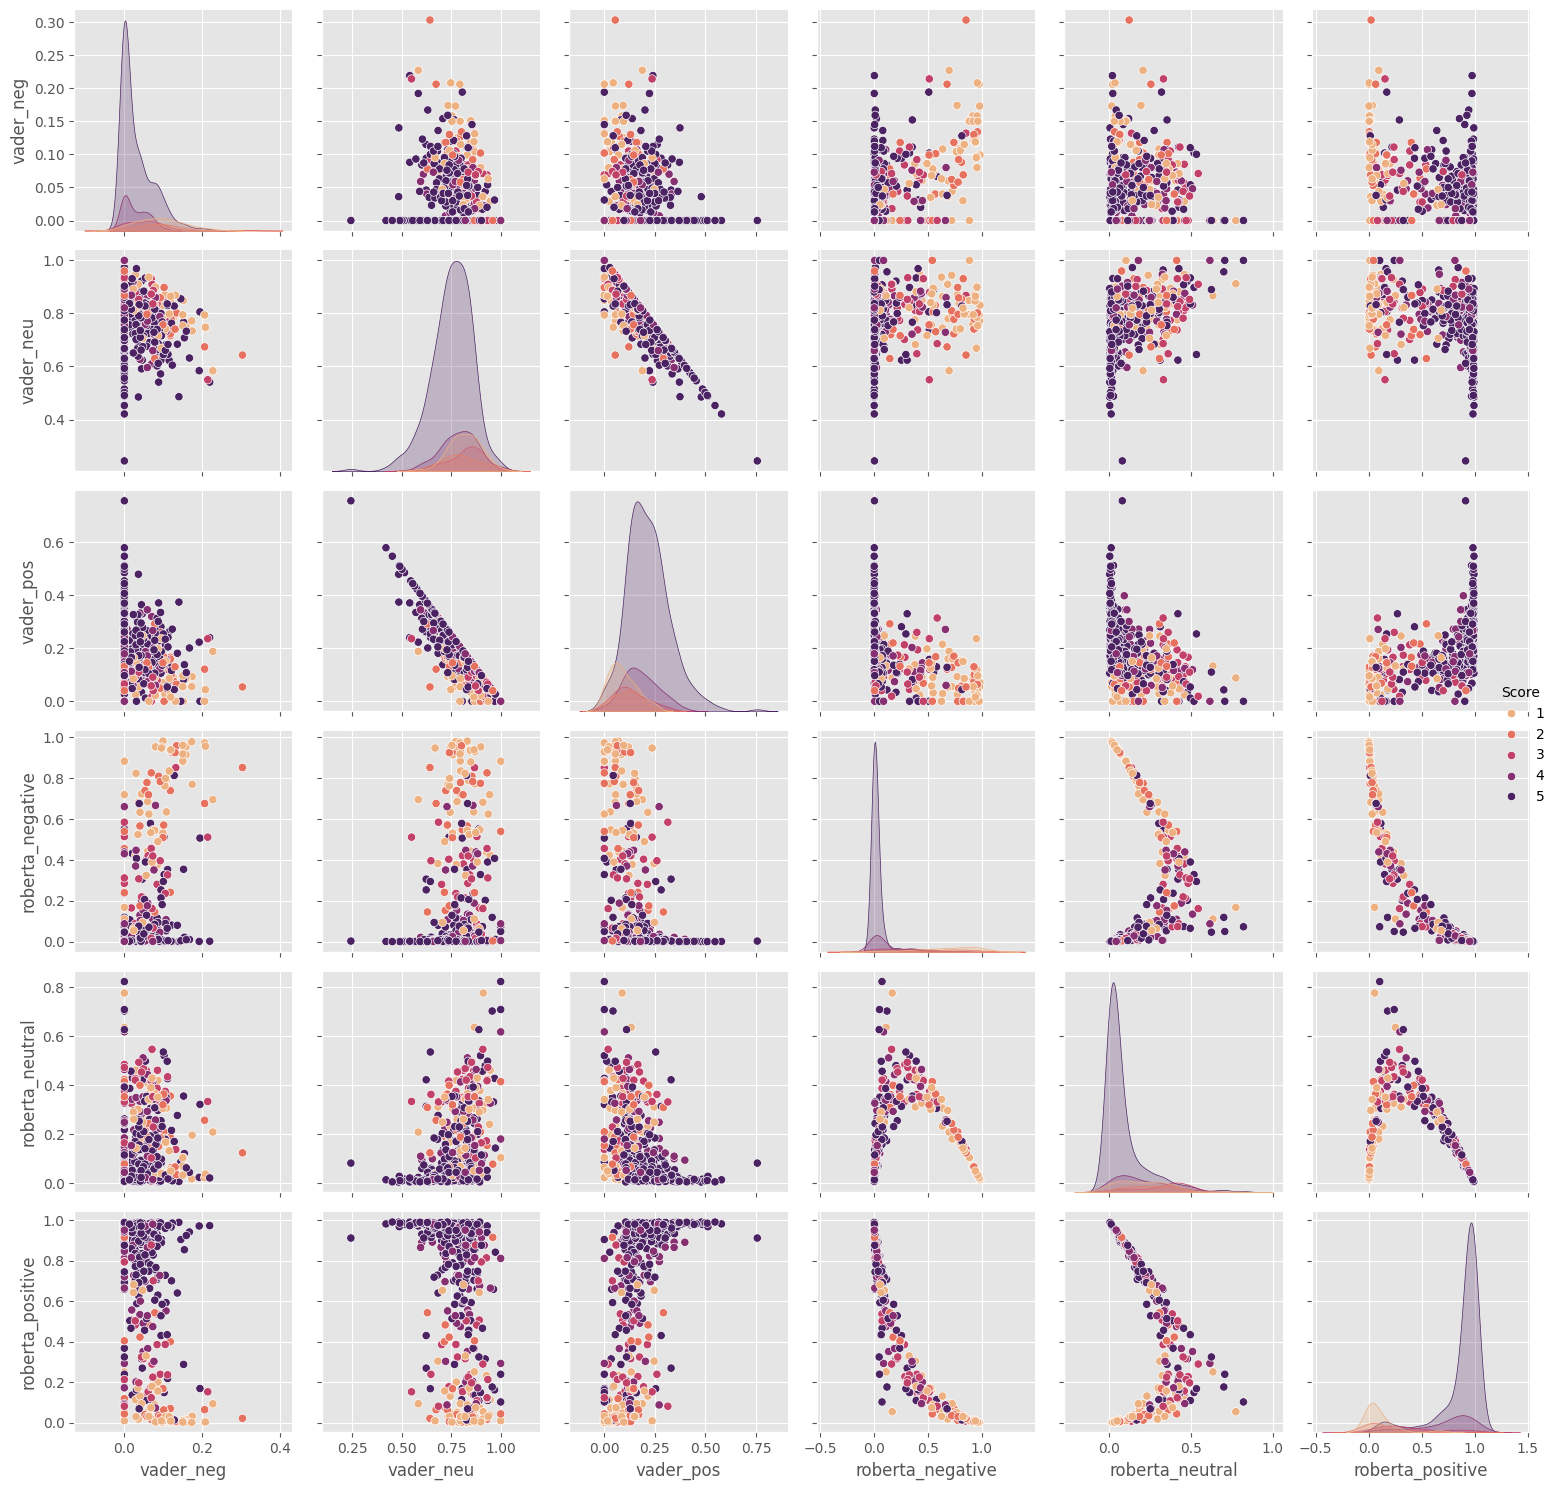

In [37]:
sns.pairplot(data=results_df, 
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_negative', 'roberta_neutral', 'roberta_positive'],
            hue='Score',
            palette='flare')

plt.tight_layout()
plt.show()

# Review Examples

- Positive 1-star and Negative 5-star ratings

Let's inspect instances wherein the model score and review score differ the most.

In [38]:
results_df.query('Score == 1') \
    .sort_values('roberta_positive', ascending=False)['Text'].values[0]

'I have two cats that are very picky eaters, sometime ago I found out about weruvia and they seemed to really enjoy it. So, in order to keep my furry friends happy and save some money I purchased weruvia online, and to my my surprise one of them would not eat it at all. I discovered that the food I purchased online unlike the one I was buying at the pet store was made in Thailand. I found a can from a previous purchase which had been made in the USA and the cat ate it without a problem. So, I wondering if anyone has had the same problems???'

In [39]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'This product was listed with a special gluten free foods promotion.  I am glad I read the ingredients first!  Although these cookies sound wonderful, buyer beware! They are not and if you are buying for someone with allergies or intolerances this would not be a wise choice.'

# Negative sentiment 5-star review

In [40]:
results_df.query('Score == 5') \
    .sort_values(by='roberta_negative', ascending=False)['Text'].values[0]

'I was in Tuscany recently, and despite my sincerest efforts was unable to sight any Tuscan Wholes.  Given the rarity of this creature, I find it hard to believe that anyone one has managed to domesticate them, let alone convince them to give milk.'

In [41]:
results_df.query('Score == 5') \
    .sort_values(by='vader_neg', ascending=False)['Text'].values[0]

'I really like the sea salt and vinegar flavor. To me it tastes better than regular potato chips. Was packaged nicely no crushed bags or broken chips!'

# Hugging Face Transformers Pipeline

- Easy way to run sentiment analysis predictions

In [42]:
from transformers import pipeline

In [43]:
sentiment_pipeline = pipeline(task='sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [44]:
sentiment_pipeline('I love sentiment analysis')

[{'label': 'POSITIVE', 'score': 0.999736487865448}]

In [45]:
sentiment_pipeline('Booooooooo')

[{'label': 'NEGATIVE', 'score': 0.504004180431366}]

In [46]:
sentiment_pipeline(example)

[{'label': 'POSITIVE', 'score': 0.9981257319450378}]

# References

- Rob Mulla. (2022). _Python Sentiment Analysis Project with NLTK and 🤗 Transformers. Classify Amazon Reviews!!_ [Video]. YouTube. https://www.youtube.com/watch?v=QpzMWQvxXWk

- Robikscube. (2022). _Sentiment Analysis Python 🤗 [Youtube Tutorial]_. Kaggle. https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook

- Stanford Network Analysis Project. (2016). _Amazon Fine Food Reviews_. Kaggle. https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews